In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'AML_dataset.csv'  # Replace with your actual file path
aml_data = pd.read_csv(file_path)

# Data Quality Checks
missing_values = aml_data.isnull().sum()
missing_percentage = (missing_values / len(aml_data)) * 100
print("Missing Value Report:\n", pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}))

# 3. Check for Duplicate Rows
duplicate_rows = aml_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# 5. Class Balance
class_distribution = aml_data['rating'].value_counts(normalize=True)
print("Class Distribution:\n", class_distribution)

# Transformations

# 1. Enhanced Transaction Features
# Combine in/out features into sums while preserving relative signals with ratios and differences
aml_data['total_cash_val_5m'] = aml_data['txn_cash_in_val_5m'] + aml_data['txn_cash_out_val_5m']
aml_data['total_cash_cnt_5m'] = aml_data['txn_cash_in_cnt_5m'] + aml_data['txn_cash_out_cnt_5m']
aml_data['total_cash_diff_5m'] = aml_data['txn_cash_in_val_5m'] - aml_data['txn_cash_out_val_5m']

aml_data['total_cash_val_3m'] = aml_data['txn_cash_in_val_3m'] + aml_data['txn_cash_out_val_3m']
aml_data['total_cash_cnt_3m'] = aml_data['txn_cash_in_cnt_3m'] + aml_data['txn_cash_out_cnt_3m']
aml_data['total_cash_diff_3m'] = aml_data['txn_cash_in_val_3m'] - aml_data['txn_cash_out_val_3m']

aml_data['total_wire_val_12m'] = aml_data['txn_wires_in_val_12m'] + aml_data['txn_wires_out_val_12m']
aml_data['total_wire_cnt_12m'] = aml_data['txn_wires_in_cnt_12m'] + aml_data['txn_wires_out_cnt_12m']
aml_data['total_wire_diff_12m'] = aml_data['txn_wires_in_val_12m'] - aml_data['txn_wires_out_val_12m']

# Add interaction terms to capture relationships between features
aml_data['cash_val_ratio_5m'] = aml_data['txn_cash_in_val_5m'] / (aml_data['txn_cash_out_val_5m'] + 1e-5)
aml_data['wire_val_ratio_12m'] = aml_data['txn_wires_in_val_12m'] / (aml_data['txn_wires_out_val_12m'] + 1e-5)

# 2. Geographical Risk Simplification
# Aggregate geographical risk levels
aml_data['geo_high_risk_count'] = aml_data[['geo_mail_addr_country_rate_high', 
                                            'geo_domicile_country_rate_high']].sum(axis=1)

aml_data['geo_med_risk_count'] = aml_data[['geo_mail_addr_country_rate_med', 
                                           'geo_domicile_country_rate_med']].sum(axis=1)

aml_data['geo_low_risk_count'] = aml_data[['geo_mail_addr_country_rate_low', 
                                           'geo_domicile_country_rate_low']].sum(axis=1)

# Drop original geographic columns to reduce redundancy
aml_data.drop(columns=[
    'geo_mail_addr_country_rate_high', 'geo_mail_addr_country_rate_med', 'geo_mail_addr_country_rate_low',
    'geo_domicile_country_rate_high', 'geo_domicile_country_rate_med', 'geo_domicile_country_rate_low'
], inplace=True)

# 3. Risk Aggregation Features
# Combine medium and high-risk indicators for interaction effects
aml_data['overall_risk_score'] = (aml_data['prod_med'] * 2 + aml_data['occu_h']).astype(int)

# 4. Log Transformation for Large Values (Reduce Skew)
# Apply log transformation to reduce skewness
for col in ['total_cash_val_5m', 'total_cash_val_3m', 'total_wire_val_12m']:
    aml_data[f'log_{col}'] = np.log1p(aml_data[col])

# 5. Interaction Features
# Create interaction terms between key features
aml_data['cash_wire_interaction_5m'] = aml_data['total_cash_val_5m'] * aml_data['total_wire_val_12m']
aml_data['product_risk_interaction'] = aml_data['prod_total_balance'] * aml_data['overall_risk_score']

# 6. Ratio Features
# Add ratios for asset and liability comparisons
aml_data['asset_liability_ratio'] = aml_data['prod_asset_balance'] / (aml_data['prod_liability_balance'] + 1e-5)
aml_data['primary_secondary_acct_ratio'] = aml_data['prod_prim_acct_cnt'] / (aml_data['prod_none_prim_acct_cnt'] + 1e-5)

# 7. Time-based Features
# Time since last major transaction (proxy using tenure and recent activity indicators)
aml_data['recent_activity_score'] = aml_data['cust_tenure'] * aml_data['in_person_visit_cnt']

# Separate features and target variable
X = aml_data.drop(columns=['rating', 'cust_id_masked'])  # Exclude identifier and target
y = aml_data['rating']

aml_data.info()

Missing Value Report:
                       Missing Values  Percentage
cust_tenure                        0         0.0
cust_cdn_resident                  0         0.0
prod_sav                           0         0.0
prod_primary_sav_cnt               0         0.0
prod_cda                           0         0.0
...                              ...         ...
tot_cash_cnt_5m                    0         0.0
avg_cash_5m                        0         0.0
avg_wire_12m                       0         0.0
cust_id_masked                     0         0.0
rating                             0         0.0

[152 rows x 2 columns]
Number of duplicate rows: 0
Class Distribution:
 rating
0    0.663265
1    0.336735
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Columns: 169 entries, cust_tenure to recent_activity_score
dtypes: float64(166), int64(2), object(1)
memory usage: 776.5+ KB


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, ParameterGrid
import pandas as pd

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': [None, 'balanced'],
    'max_features': ['sqrt', 'log2', None]
}

# Create a parameter grid to iterate over
grid = ParameterGrid(param_grid)

# Store results
results = []

# Iterate over each parameter combination
for params in grid:
    # Train a Random Forest model with the current parameters
    rf = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    rf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1] if hasattr(rf, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    # Store the results
    results.append({
        'Params': params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Convert results to a DataFrame for inspection
results_df = pd.DataFrame(results)

# Sort the results by F1 Score and then by ROC AUC in descending order
results_df = results_df.sort_values(by=['F1 Score', 'ROC AUC'], ascending=[False, False])

# Display the top results
print("Top models by F1 Score and ROC AUC:")
print(results_df.head())

# Get the best hyperparameters (highest F1 Score, then highest ROC AUC if tied)
best_params = results_df.iloc[0]['Params']
print("\nBest Hyperparameters:")
print(best_params)

# Print the best metric values
best_metrics = results_df.iloc[0]
print("\nBest Metrics:")
print(best_metrics)

Top models by F1 Score and ROC AUC:
                                               Params  Accuracy  Precision  \
25  {'class_weight': None, 'max_depth': 20, 'max_f...  0.864407   0.821429   
24  {'class_weight': None, 'max_depth': 20, 'max_f...  0.864407   0.821429   
26  {'class_weight': None, 'max_depth': 20, 'max_f...  0.855932   0.793103   
7   {'class_weight': None, 'max_depth': None, 'max...  0.855932   0.814815   
8   {'class_weight': None, 'max_depth': None, 'max...  0.847458   0.766667   

      Recall  F1 Score   ROC AUC  
25  0.676471  0.741935  0.858894  
24  0.676471  0.741935  0.857843  
26  0.676471  0.730159  0.856618  
7   0.647059  0.721311  0.854167  
8   0.676471  0.718750  0.853817  

Best Hyperparameters:
{'class_weight': None, 'max_depth': 20, 'max_features': None, 'n_estimators': 100}

Best Metrics:
Params       {'class_weight': None, 'max_depth': 20, 'max_f...
Accuracy                                              0.864407
Precision                             

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model to get feature importances using the specified hyperparameters
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight=None,
    max_depth=20,
    max_features=None,
    n_estimators=100
)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Find the optimal number of features to use
results = []
for num_features in range(10, len(feature_importances) + 1, 10):  # Adjust step size if necessary
    top_features = feature_importances['Feature'].head(num_features)
    X_top = X[top_features]
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)
    
    # Train a Random Forest model with the specified hyperparameters
    rf_top = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight=None,
        max_depth=20,
        max_features=None,
        n_estimators=100
    )
    rf_top.fit(X_train_top, y_train_top)
    
    # Evaluate metrics
    y_pred_top = rf_top.predict(X_test_top)
    y_pred_proba_top = rf_top.predict_proba(X_test_top)[:, 1]
    accuracy = accuracy_score(y_test_top, y_pred_top)
    precision = precision_score(y_test_top, y_pred_top, zero_division=0)
    recall = recall_score(y_test_top, y_pred_top, zero_division=0)
    f1 = f1_score(y_test_top, y_pred_top, zero_division=0)
    roc_auc = roc_auc_score(y_test_top, y_pred_proba_top)
    
    # Append results
    results.append({
        'Num Features': num_features,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame by F1 Score first, then by ROC AUC in descending order
results_df = results_df.sort_values(by=['F1 Score', 'ROC AUC'], ascending=[False, False])

# Display performance metrics
print("Performance metrics for different numbers of top features:")
print(results_df)

# Get the best number of features based on the sorted results
best_result = results_df.iloc[0]
print("\nOptimal number of features based on F1 Score and ROC AUC:")
print(best_result)


Performance metrics for different numbers of top features:
    Num Features  Accuracy  Precision    Recall  F1 Score   ROC AUC
4             50  0.864407   0.800000  0.705882  0.750000  0.857493
6             70  0.864407   0.800000  0.705882  0.750000  0.855567
3             40  0.864407   0.800000  0.705882  0.750000  0.853291
11           120  0.855932   0.774194  0.705882  0.738462  0.858193
7             80  0.855932   0.793103  0.676471  0.730159  0.848214
0             10  0.838983   0.714286  0.735294  0.724638  0.851541
13           140  0.847458   0.766667  0.676471  0.718750  0.860119
2             30  0.847458   0.766667  0.676471  0.718750  0.858368
10           110  0.847458   0.766667  0.676471  0.718750  0.856443
14           150  0.847458   0.766667  0.676471  0.718750  0.853992
9            100  0.847458   0.785714  0.647059  0.709677  0.856443
5             60  0.838983   0.741935  0.676471  0.707692  0.859419
12           130  0.838983   0.741935  0.676471  0.707692

In [6]:
# Based on the results, choose the optimal number of features (e.g., 50)
optimal_num_features = 50
top_features_optimal = feature_importances['Feature'].head(optimal_num_features)
X_optimal = X[top_features_optimal]
X_train_optimal, X_test_optimal, y_train_optimal, y_test_optimal = train_test_split(X_optimal, y, test_size=0.2, random_state=42)

# Train the final Random Forest model on optimal features
final_rf_model = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight=None,
        max_depth=20,
        max_features=None,
        n_estimators=100
    )
final_rf_model.fit(X_train_optimal, y_train_optimal)

# Test an example and compare to the actual result
example_index = 114 # Change this index to test different samples from X_test_optimal
example_features = X_test_optimal.iloc[example_index, :].values.reshape(1, -1)
predicted_proba = final_rf_model.predict_proba(example_features)[0, 1]
predicted_class = final_rf_model.predict(example_features)[0]
actual_class = y_test_optimal.iloc[example_index]

print("\nTesting a single example:")
print("Predicted Probability (High Risk):", predicted_proba)
print("Predicted Class (1 = High, 0 = Non-High):", predicted_class)
print("Actual Class (1 = High, 0 = Non-High):", actual_class)

threshold = 0.5
final_decision = "High Risk" if predicted_proba >= threshold else "Non-High Risk"
print("Final Decision based on threshold:", final_decision)
print("Comparison: Predicted Class vs. Actual Class -", "Correct" if predicted_class == actual_class else "Incorrect")


Testing a single example:
Predicted Probability (High Risk): 0.56
Predicted Class (1 = High, 0 = Non-High): 1
Actual Class (1 = High, 0 = Non-High): 1
Final Decision based on threshold: High Risk
Comparison: Predicted Class vs. Actual Class - Correct


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


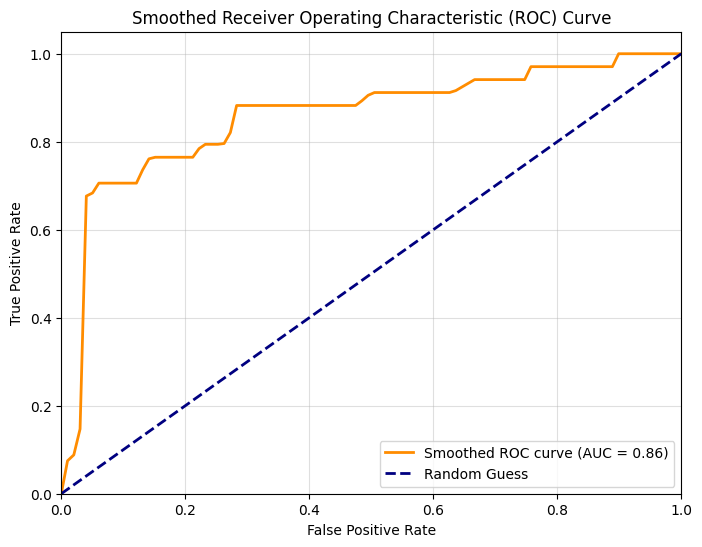

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (High Risk)
y_pred_proba = final_rf_model.predict_proba(X_test_optimal)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_optimal, y_pred_proba)

# Smooth the curve by interpolating the points
fpr_smooth = np.linspace(fpr.min(), fpr.max(), 100)  # Generate 100 evenly spaced points
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)  # Interpolate TPR values at the new FPR points

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the smoothed ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_smooth, tpr_smooth, color='darkorange', lw=2, label=f"Smoothed ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Smoothed Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()


In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Get predicted probabilities for the test set
y_proba_test = final_rf_model.predict_proba(X_test_optimal)[:, 1]

# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.05)

# Store results for each threshold
threshold_results = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_threshold = (y_proba_test >= threshold).astype(int)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test_optimal, y_pred_threshold)
    precision = precision_score(y_test_optimal, y_pred_threshold, zero_division=0)
    recall = recall_score(y_test_optimal, y_pred_threshold, zero_division=0)
    f1 = f1_score(y_test_optimal, y_pred_threshold, zero_division=0)
    
    # Append results
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Convert results to DataFrame for easy viewing
threshold_results_df = pd.DataFrame(threshold_results)
print(threshold_results_df)

# Find the threshold with the best F1 Score (or any other metric you prefer)
best_threshold = threshold_results_df.loc[threshold_results_df['F1 Score'].idxmax(), 'Threshold']
print("\nOptimal Threshold based on F1 Score:", round(best_threshold, 2))

# Set the best threshold in your final decision logic
threshold = best_threshold

    Threshold  Accuracy  Precision    Recall  F1 Score
0        0.10  0.457627   0.340426  0.941176  0.500000
1        0.15  0.584746   0.402597  0.911765  0.558559
2        0.20  0.677966   0.468750  0.882353  0.612245
3        0.25  0.711864   0.500000  0.882353  0.638298
4        0.30  0.737288   0.526316  0.882353  0.659341
5        0.35  0.754237   0.551020  0.794118  0.650602
6        0.40  0.805085   0.634146  0.764706  0.693333
7        0.45  0.830508   0.694444  0.735294  0.714286
8        0.50  0.864407   0.800000  0.705882  0.750000
9        0.55  0.881356   0.884615  0.676471  0.766667
10       0.60  0.822034   0.842105  0.470588  0.603774
11       0.65  0.813559   0.833333  0.441176  0.576923
12       0.70  0.788136   0.800000  0.352941  0.489796
13       0.75  0.771186   0.769231  0.294118  0.425532
14       0.80  0.737288   0.666667  0.176471  0.279070
15       0.85  0.720339   0.600000  0.088235  0.153846
16       0.90  0.728814   0.750000  0.088235  0.157895
17       0

In [15]:
# Based on the results, choose the optimal number of features (e.g., 50)
optimal_num_features = 20
top_features_optimal = feature_importances['Feature'].head(optimal_num_features)
X_optimal = X[top_features_optimal]
X_train_optimal, X_test_optimal, y_train_optimal, y_test_optimal = train_test_split(X_optimal, y, test_size=0.2, random_state=42)

# Train the final Random Forest model on optimal features
final_rf_model = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight=None,
        max_depth=20,
        max_features=None,
        n_estimators=50
    )
final_rf_model.fit(X_train_optimal, y_train_optimal)

# Test an example and compare to the actual result
example_index = 114  # Change this index to test different samples from X_test_optimal
example_features = X_test_optimal.iloc[example_index, :].values.reshape(1, -1)
predicted_proba = final_rf_model.predict_proba(example_features)[0, 1]
predicted_class = final_rf_model.predict(example_features)[0]
actual_class = y_test_optimal.iloc[example_index]

print("\nTesting a single example:")
print("Predicted Probability (High Risk):", predicted_proba)
print("Predicted Class (1 = High, 0 = Non-High):", predicted_class)
print("Actual Class (1 = High, 0 = Non-High):", actual_class)

threshold = 0.5
final_decision = "High Risk" if predicted_proba >= threshold else "Non-High Risk"
print("Final Decision based on threshold:", final_decision)
print("Comparison: Predicted Class vs. Actual Class -", "Correct" if predicted_class == actual_class else "Incorrect")


Testing a single example:
Predicted Probability (High Risk): 0.56
Predicted Class (1 = High, 0 = Non-High): 1
Actual Class (1 = High, 0 = Non-High): 1
Final Decision based on threshold: High Risk
Comparison: Predicted Class vs. Actual Class - Correct


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


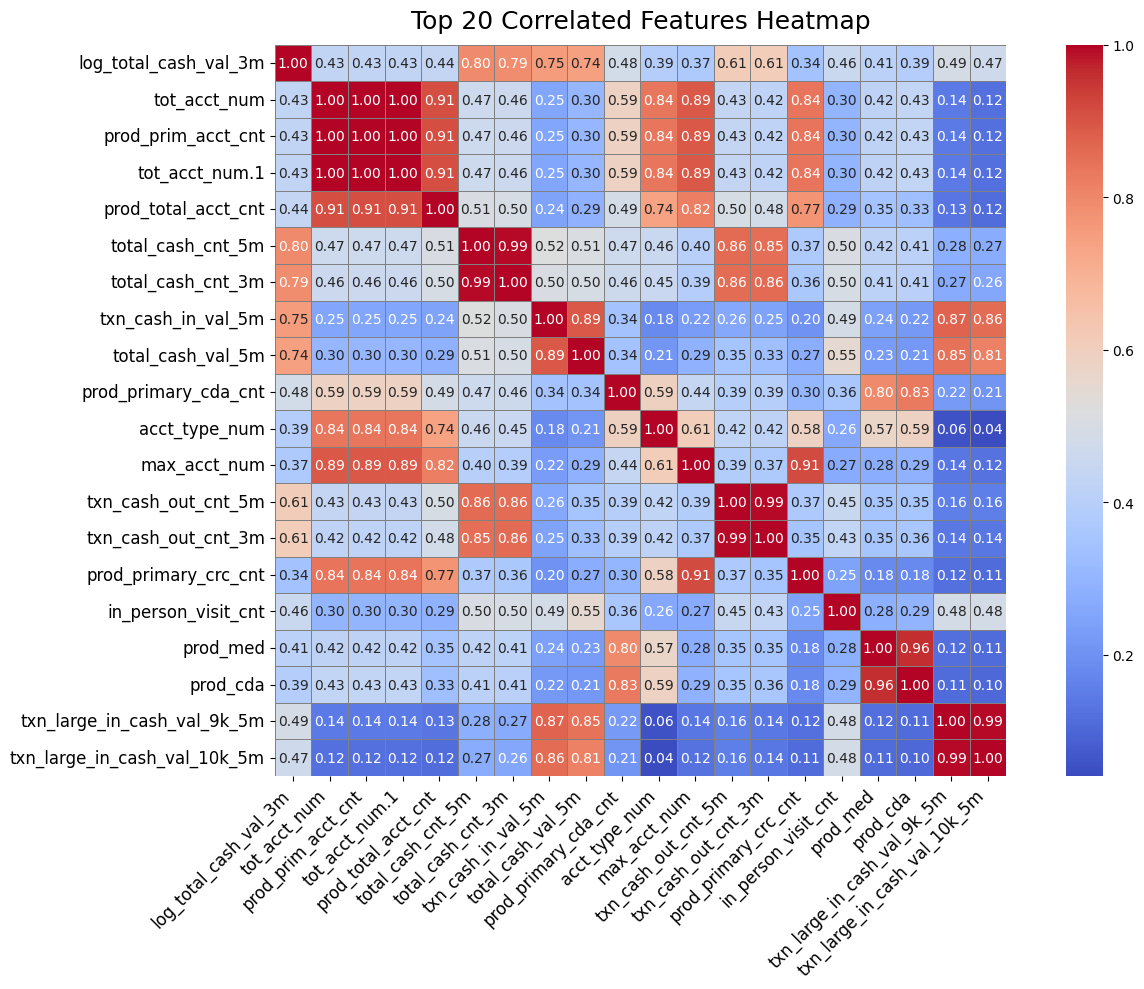

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = X_train_optimal.corr()

# Select the top 20 correlated features based on absolute mean correlation
top_correlated_features = correlation_matrix.abs().mean().sort_values(ascending=False).head(20).index
filtered_correlation_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

# Improve Heatmap Aesthetics
plt.figure(figsize=(14, 10))
sns.heatmap(
    filtered_correlation_matrix,
    annot=True,
    cmap="coolwarm",
    cbar=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    linewidths=0.5,  # Add grid lines for better separation
    linecolor="gray"
)
plt.title("Top 20 Correlated Features Heatmap", fontsize=18, pad=12)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/my/5pbqkp817313j1bx7jlmbynr0000gn/T/ipykernel_17984/1700623116.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


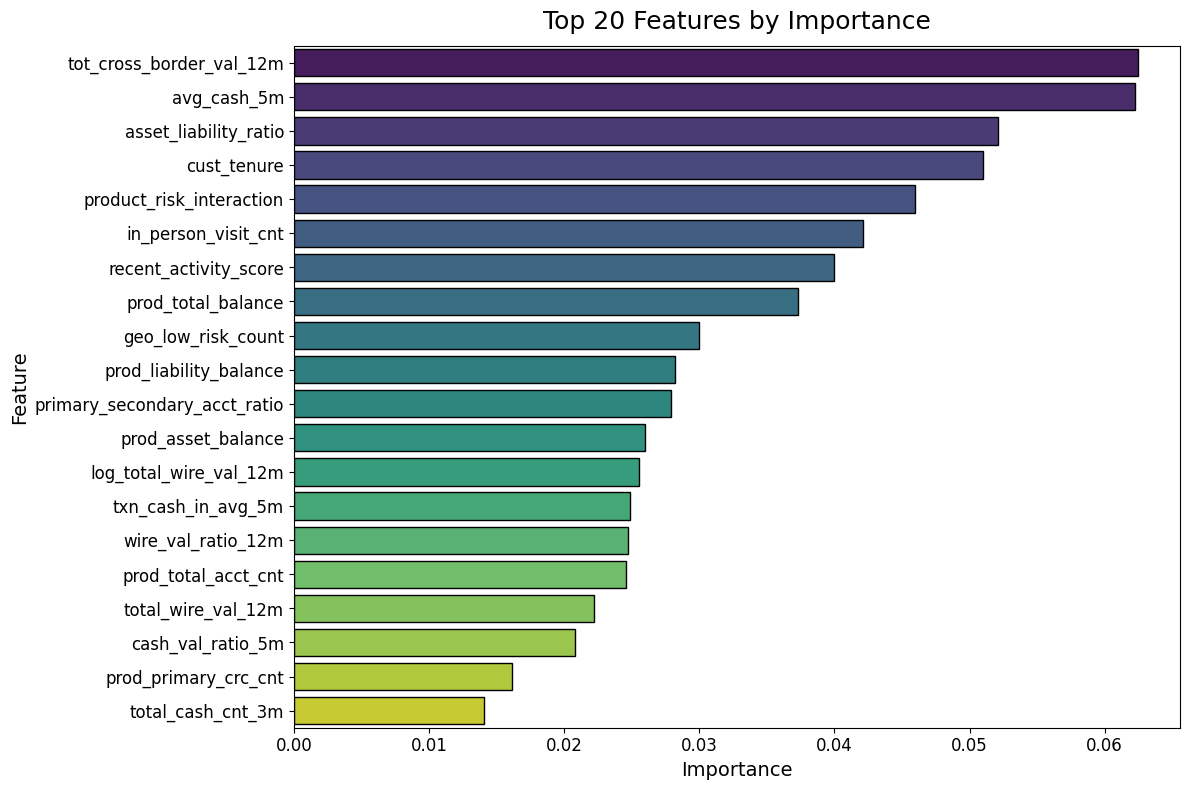

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract top 20 most important features from feature_importances
top_important_features = feature_importances.head(20)  # Ensure this DataFrame exists from earlier calculations

# Plot a bar graph for the top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Importance",
    y="Feature",
    data=top_important_features,
    palette="viridis",
    edgecolor="black"
)
plt.title("Top 20 Features by Importance", fontsize=18, pad=12)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
